In [29]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [30]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 24,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 4,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

# Clean time series data
## (1) Normalize $(v_{t} \to n_{t}): n_{t} = \frac{v_{t} - \mu_{v}}{\sigma_{v}}$
## (2) First Difference $(n_{t} \to d_{t}): d_{t} = n_{t} - n_{t-1} = \frac{v_{t} - \mu_{v}}{\sigma_{v}} - \frac{v_{t -1} - \mu_{v}}{\sigma_{v}}$ 
## (3) Remove increasing volatility $(d_{t} \to r_{t}): r_{t} = \frac{d_{t}}{\sigma_{d_{t}}} = \frac{\frac{v_{t} - \mu_{v}}{\sigma_{v}} - \frac{v_{t -1} - \mu_{v}}{\sigma_{v}}}{\sigma_{d_{t}}}$

In [31]:
def split_data_time_over(period, cfg):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    num_data_points = len(df)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)

    data_travel_time = [float(df.loc[df.index == date]['delta_t']) for date in df.index]
    data_travel_time = np.array(data_travel_time)

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        tmp_time = pd.Series(time[part_time_idx], name='datetime')
        tmp_travel_time = pd.Series(travel_time[part_time_idx], name='travel_time')
        df = pd.concat([tmp_time, tmp_travel_time], axis=1)
        df = df.set_index('datetime')
        df_list.append(df)

    return df_list

In [32]:
df = split_data_time_over(3, cfg)

In [33]:
def plot_series(series):
    plt.figure(figsize=(20, 6))
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='red')

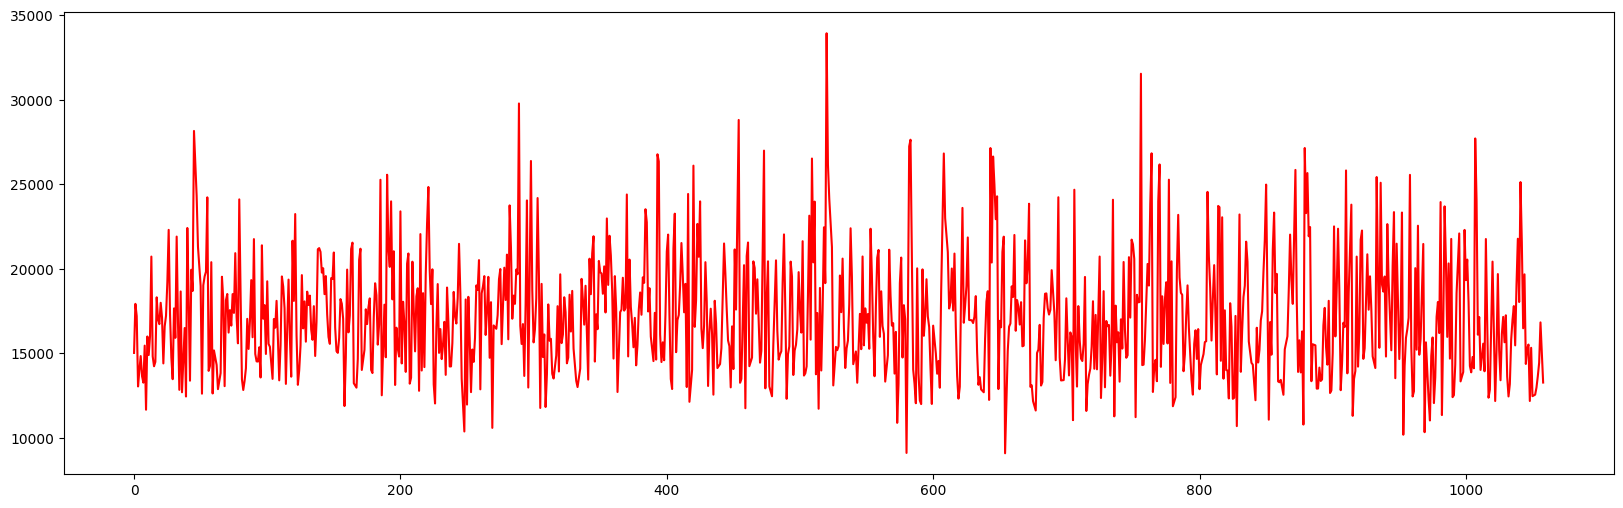

In [34]:
plot_series(df[0]['travel_time'])
plt.show()

## Normalize

In [7]:
avg, dev = df[0]['travel_time'].mean(), df[0]['travel_time'].std()

In [8]:
travel_time_series = (df[0]['travel_time'] - avg) / dev

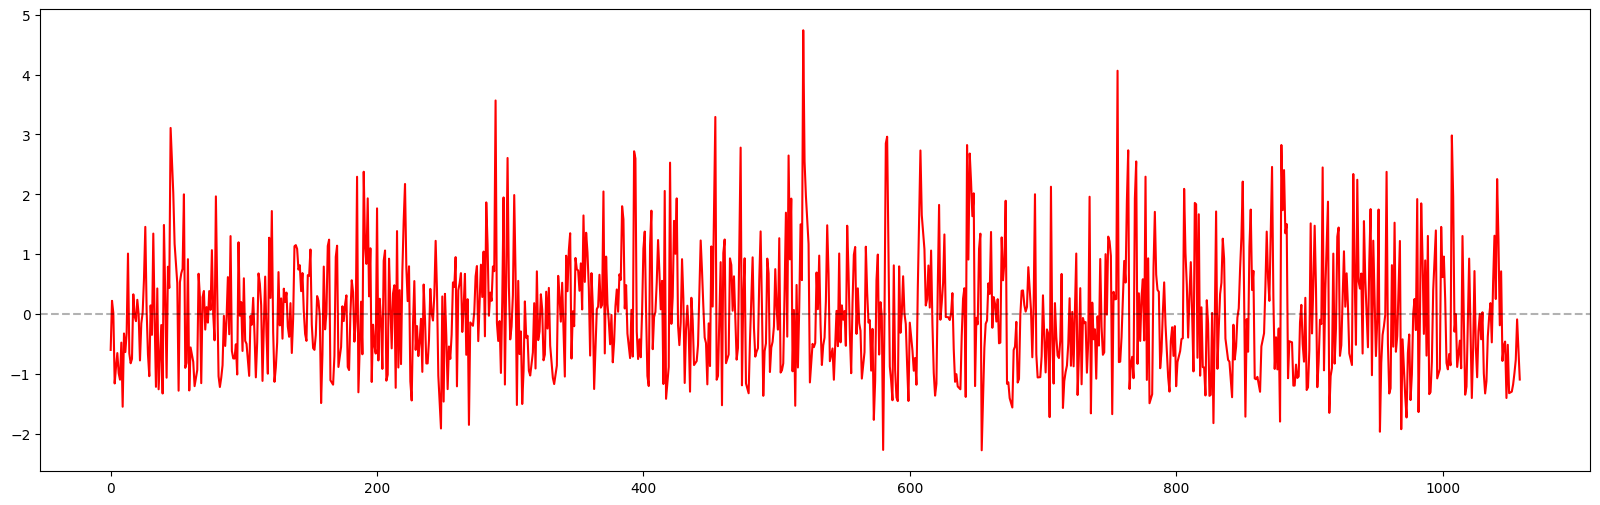

In [9]:
plot_series(travel_time_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.show()

## First Difference

In [10]:
travel_time_series = travel_time_series.diff().dropna()

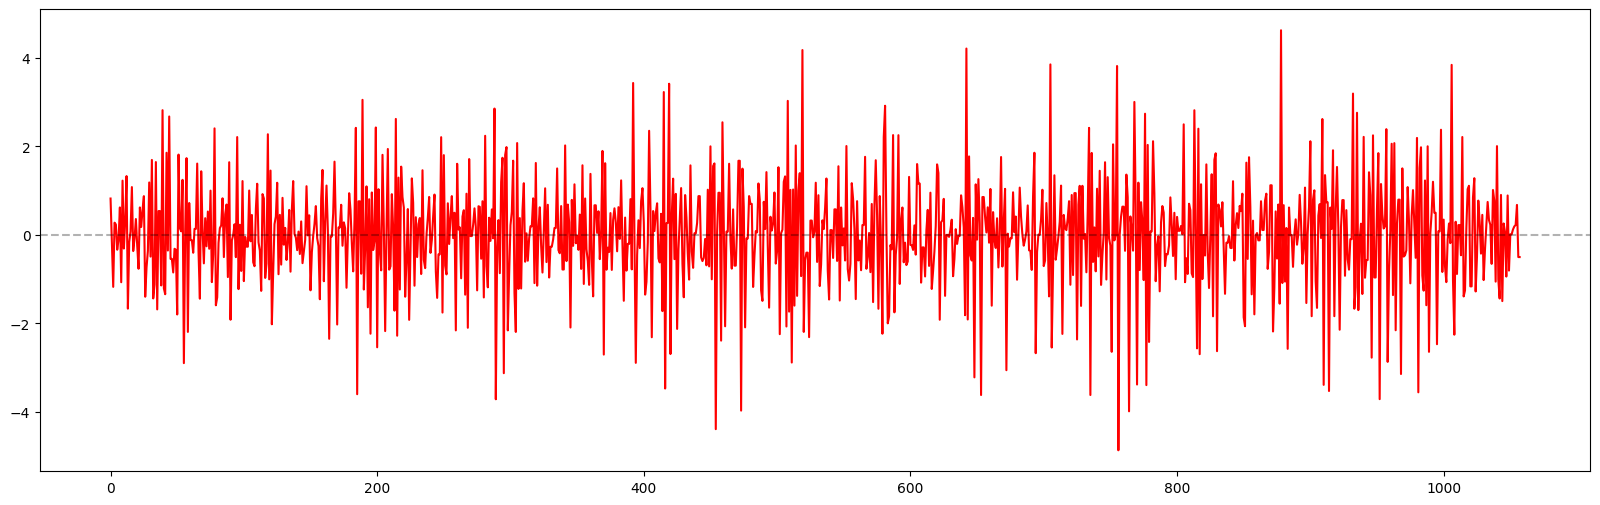

In [11]:
plot_series(travel_time_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.show()

## Remove increasing volatility

In [12]:
annual_volatility = travel_time_series.groupby(travel_time_series.index.hour).std()

In [13]:
annual_volatility

datetime
0    1.324456
1    1.187324
2    1.174523
Name: travel_time, dtype: float64

In [14]:
travel_time_annual_vol = travel_time_series.index.map(lambda d: annual_volatility.loc[d.hour])

In [15]:
travel_time_annual_vol

Float64Index([ 1.187323801914793, 1.1745229188515791, 1.3244564481499062,
               1.187323801914793, 1.1745229188515791, 1.3244564481499062,
               1.187323801914793, 1.1745229188515791, 1.3244564481499062,
               1.187323801914793,
              ...
              1.1745229188515791, 1.3244564481499062,  1.187323801914793,
              1.1745229188515791, 1.3244564481499062,  1.187323801914793,
              1.1745229188515791, 1.3244564481499062,  1.187323801914793,
              1.1745229188515791],
             dtype='float64', name='datetime', length=1058)

In [16]:
travel_time_series = travel_time_series / travel_time_annual_vol

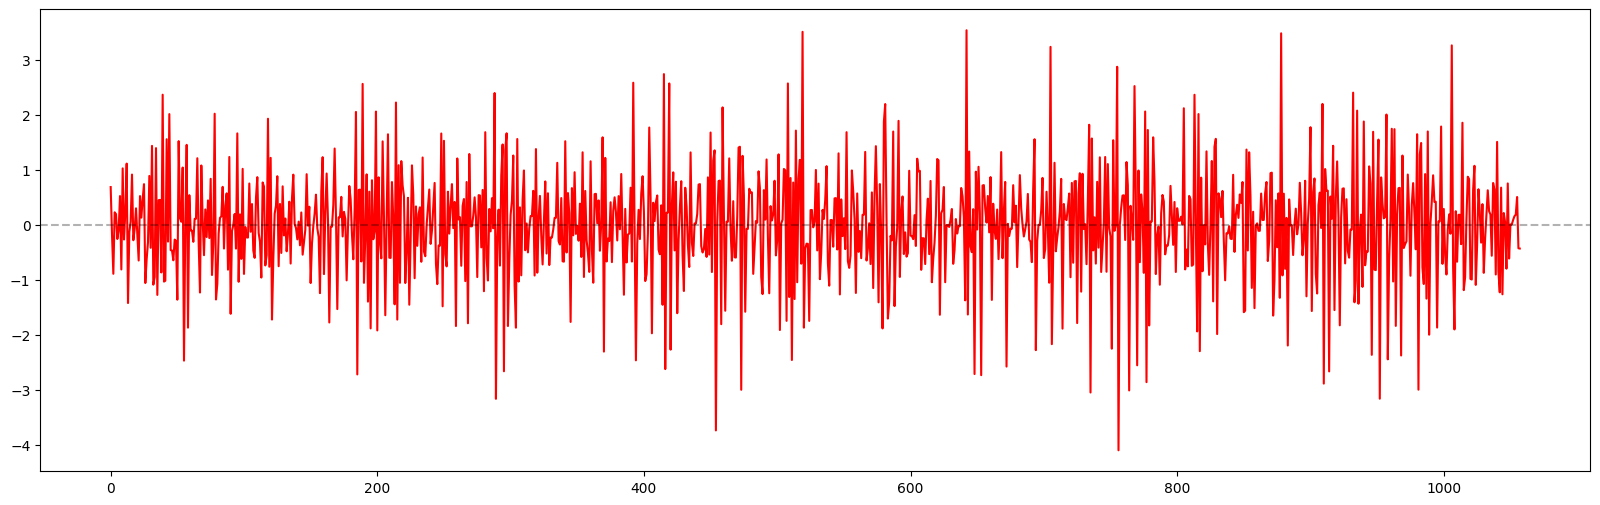

In [17]:
plot_series(travel_time_series)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.show()

# Class

In [18]:
class Normalizer:
    def __init__(self):
        self.normalize_data = None
        self.std_data = 0
        self.mean_data = 0
        self.std_diff = None

    def fit_transform(self, data):
        # normalize
        self.mean_data, self.std_data = data.mean(), data.std()
        self.normalize_data = (data - self.mean_data) / self.std_data
        
        # first difference
        diff_data = self.normalize_data.diff().fillna(self.normalize_data)
        
        # remove increasing volatility
        self.std_diff = diff_data.groupby(diff_data.index.hour).std()
        data_hourly_volatility = diff_data.index.map(lambda d: self.std_diff.loc[d.hour])

        remove_data = diff_data / data_hourly_volatility

        # remove seasonal
        

        return remove_data

    def inverse_transform(self, data, split_data_index):
        print(data.shape)
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            if (idx + split_data_index) == 0:
                _data = (self.std_data * (self.std_diff[data.index[idx].hour] * data[idx])) + self.mean_data
            else:
                _data = (self.std_data * ((self.std_diff[data.index[idx].hour] * data[idx]) + self.normalize_data[(idx - 1) + split_data_index])) + self.mean_data
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series
    

In [19]:
scaler = Normalizer()

In [20]:
travel_time = scaler.fit_transform(df[0]['travel_time'])

In [21]:
travel_time

datetime
2019-01-01 00:00:00   -0.454584
2019-01-01 01:00:00    0.690567
2019-01-01 02:00:00   -0.173962
2019-01-02 00:00:00   -0.888725
2019-01-02 01:00:00    0.231062
                         ...   
2019-12-30 01:00:00    0.159783
2019-12-30 02:00:00    0.189809
2019-12-31 00:00:00    0.510474
2019-12-31 01:00:00   -0.423270
2019-12-31 02:00:00   -0.427883
Length: 1059, dtype: float64

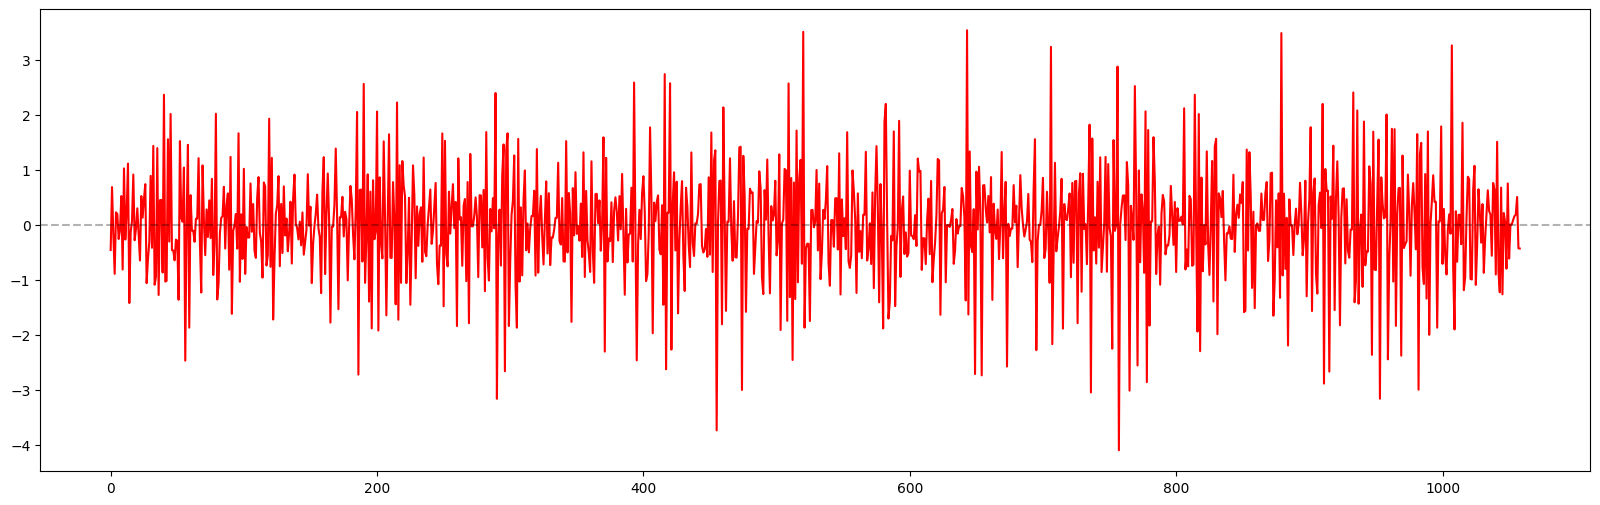

In [22]:
plot_series(travel_time)
plt.axhline(0, linestyle='--', color='k', alpha=0.3)
plt.show()

In [23]:
df[0]

,travel_time
datetime,
2019-01-01 00:00:00,15034.000000
2019-01-01 01:00:00,17934.000000
2019-01-01 02:00:00,17211.333333
2019-01-02 00:00:00,13053.000000
2019-01-02 01:00:00,14023.333333
...,...
2019-12-30 01:00:00,13661.000000
2019-12-30 02:00:00,14449.500000
2019-12-31 00:00:00,16838.000000


In [24]:
inverse = scaler.inverse_transform(travel_time, 0)

(1059,)


In [25]:
scaler_1 = StandardScaler()

In [27]:
inverse_1 = scaler_1.fit_transform(df[0])

In [35]:
len(inverse_1)

1059

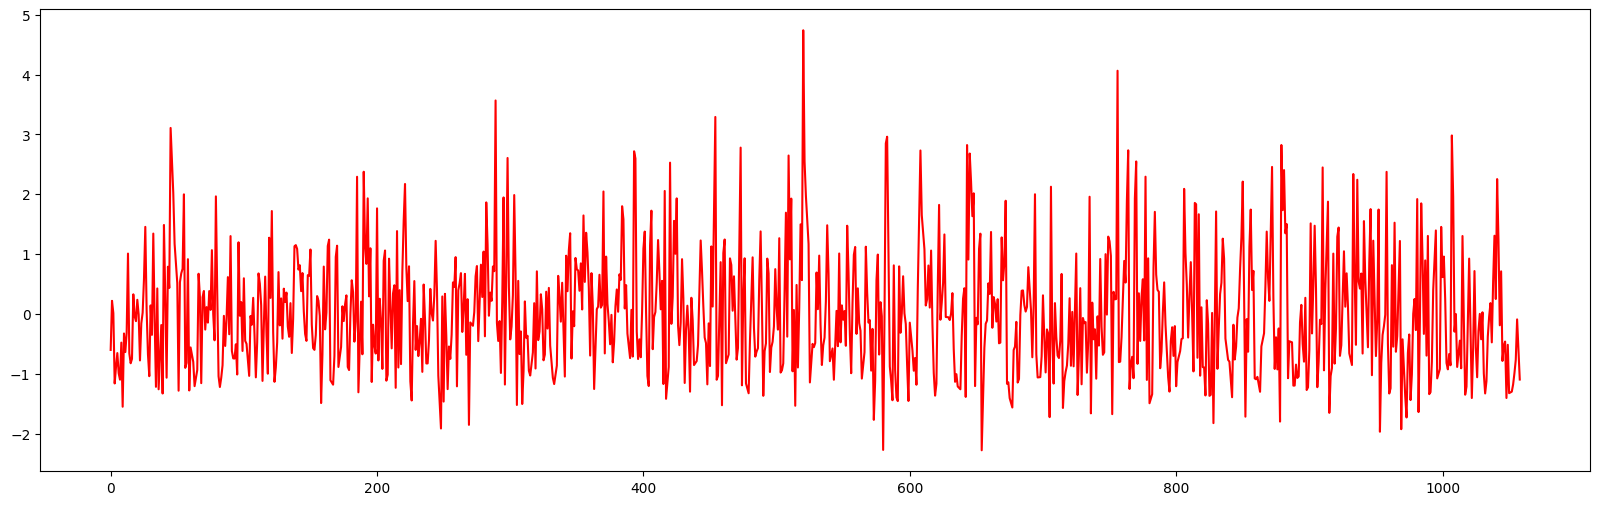

In [36]:
plot_series(inverse_1)
plt.show()